# Multi-modal Distribution Experiments

Install Pyro.

In [1]:
!pip3 install pyro-ppl

Import necessary modules.

In [2]:
import numpy as np

import torch
from torch.distributions import constraints

import time

import random

import pyro
import pyro.distributions as dist
from pyro import poutine
from pyro.infer import SVI, TraceEnum_ELBO, config_enumerate
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoDelta

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

A class to model and sample from mixture of Gaussians. The class can instantiate mixtures of arbitrary Gaussians but it makes the simplifying assumption that the Gaussian components have equal weights. 

In [3]:
class GMM:

    def __init__(self, k, d, locs, scales):

        self.k = k
        self.d = d

        assert locs.size() == (k, d), 'Input locs must be a tensor of size (%i, %i)' % (k, d)
        self.locs = locs

        assert scales.size() == (k, d, d), 'Input scales must be a tensor of size (%i, %i, %i)' % (k, d, d)
        self.scales = scales

        self.init_gaussians()

    def init_gaussians(self):

        self.gaussians = [dist.MultivariateNormal(self.locs[i], self.scales[i]) for i in range(self.k)]

    def log_likelihood(self, params):

        total_log_prob = 0
        for gaussian in self.gaussians:
            total_log_prob += gaussian.log_prob(params)

        return total_log_prob / self.k

    def sample(self, n):

        m = n // self.k 
        m_last = m + n % self.k
        m_first = m_last if m == 0 else m

        shuffled_gaussians = random.sample(self.gaussians, self.k)

        samples = torch.stack([pyro.sample('samples1', shuffled_gaussians[0]) for _ in range(m_first)])
        assignments = torch.tensor([0] * m_first)

        for i in range(1, self.k - 1):
            new_samples = torch.stack([pyro.sample('samples' + str(i + 1), shuffled_gaussians[i]) for _ in range(m)])
            new_assignments = torch.tensor([i] * m)
            samples = torch.cat((samples, new_samples))
            assignments =  torch.cat((assignments, new_assignments))

        last_samples = torch.stack([pyro.sample('samples' + str(self.k), shuffled_gaussians[-1]) for _ in range(m_last)])
        last_assignments = torch.tensor([self.k - 1] * m_last)
        samples = torch.cat((samples, last_samples))
        assignments =  torch.cat((assignments, last_assignments))

        random_indices = torch.randperm(n)
        samples = samples[random_indices] 
        assignments = assignments[random_indices]

        return samples, assignments

## GMM Usage

**K** = # of Gaussian Components

**D** = Data Dimensionality

**LOCS** = Tensor storing Gaussian means

**SCALES** = Tensor storing Gaussian covariances

Set the below constants to generate a mixture of arbitrary Gaussians. For simplicity the model takes the weight of all gaussians equal, and again for simplicity a Bimodal distribution is used in this example. More complicated distributions can be obtained by simply setting K, D, LOCS and SCALES.

In [4]:
K = 2 

D = 2 

LOCS = torch.tensor([[2, 2], [5, 5]], dtype=torch.float)

SCALES = torch.tensor([[[.5, .25],
                        [.25, 1.]],
                       [[.5, -.25],
                        [-.25, 1.]]], dtype=torch.float)

Initialize a simple Bimodal.

In [5]:
BIMODAL = GMM(K, D, LOCS, SCALES)

Sample from the Bimodal. 

In [6]:
N = 10000

assert N > K, 'Dataset size N must be greater'

data, assignments = BIMODAL.sample(N)

data, assignments

(tensor([[2.7595, 1.1963],
         [1.7993, 1.6980],
         [1.7095, 2.1715],
         ...,
         [2.4316, 1.7484],
         [2.4796, 1.3559],
         [2.2648, 3.0082]]), tensor([0, 0, 0,  ..., 0, 0, 0]))

Split samples into training and test sets. 

In [7]:
def split_data(y, x, ratio=0.8):
  
  n_train = int(y.size()[0] * ratio)
  n_test = y.size()[0] - n_train

  y_train = y[:n_train]
  x_train = x[:n_train]
  
  y_test = y[n_train:]
  x_test = x[n_train:]
  
  return y_train, x_train, y_test, x_test, n_train, n_test

In [8]:
y_train, x_train, y_test, x_test, n_train, n_test = split_data(assignments, data)

## Pyro Inference Part

Set means and covariances in random to start ADVI from. 

In [9]:
torch.manual_seed(7)
random.seed(7)

random_locs = torch.rand(D) 

temp = torch.rand(D, D)
random_scales = temp @ temp.T

for _ in range(K - 1):
    
    random_locs = torch.stack((random_locs, torch.rand(D)))

    temp = torch.rand(D, D)
    random_scales = torch.stack((random_scales, temp @ temp.T))
    
max_locs = torch.max(LOCS, 0).values
random_locs = random_locs * max_locs

random_locs, random_scales

(tensor([[2.6746, 0.9940],
         [1.0354, 3.1487]]), tensor([[[0.8661, 0.4327],
          [0.4327, 0.2349]],
 
         [[0.8581, 0.7813],
          [0.7813, 1.0345]]]))

Define the Pyro model to run inference on.

In [10]:
@config_enumerate(default='parallel')
@poutine.broadcast
def model(data):

    # Global variables
    weights = pyro.param('weights', torch.FloatTensor([1 / K]), constraint=constraints.unit_interval)
    locs = pyro.param('locs', random_locs)
    scales = pyro.param('scales', random_scales)

    with pyro.iarange('data', data.size(0)):
        # Local variables
        assignment = pyro.sample('assignment', dist.Bernoulli(torch.ones(len(data)) * weights)).to(torch.int64)
        pyro.sample('obs', dist.MultivariateNormal(locs[assignment], scales[assignment]), obs=data)

In [11]:
@config_enumerate(default='parallel')
@poutine.broadcast
def full_guide(data):
    with pyro.iarange('data', data.size(0)):
        # Local variables
        assignment_probs = pyro.param('assignment_probs', torch.ones(len(data)) / K, constraint=constraints.unit_interval)
        pyro.sample('assignment', dist.Bernoulli(assignment_probs), infer={'enumerate': 'sequential'})

In [12]:
def initialize(data):
    pyro.clear_param_store()

    optim = pyro.optim.Adam({'lr': 0.1, 'betas': [0.8, 0.99]})
    elbo = TraceEnum_ELBO(max_iarange_nesting=1)
    svi = SVI(model, full_guide, optim, loss=elbo)

    # Initialize weights to uniform
    pyro.param('auto_weights', 0.5 * torch.ones(K), constraint=constraints.simplex)

    # Assume half of the data variance is due to intra-component noise
    var = (data.var() / 2).sqrt()
    pyro.param('auto_scale', torch.tensor([var] * 4), constraint=constraints.positive)

    # Initialize means from a subsample of data
    pyro.param('auto_locs', data[torch.multinomial(torch.ones(len(data)) / len(data), K)])

    loss = svi.loss(model, full_guide, data)

    return loss, svi

Plotting function to visualise 2-dimensional models. 

In [13]:
def plot(data, locs=None, scales=None, color='black', figname='fig.png'):
    
    # Create figure
    fig = plt.figure()

    # Plot data
    x = data[:, 0]
    y = data[:, 1]
    plt.scatter(x, y, 24, c=color)

    # Plot cluster centers
    if locs is not None:
        x = [float(m[0]) for m in locs]
        y = [float(m[1]) for m in locs]
        plt.scatter(x, y, 99, c='red')

    # Plot ellipses for each cluster
    if scales is not None:
        for k in range(K):
            ax = fig.gca()
            cov = np.array(scales[k])
            lam, v = np.linalg.eig(cov)
            lam = np.sqrt(lam)
            ell = Ellipse(xy=(x[k], y[k]),
                          width=lam[0] * 4, height=lam[1] * 4,
                          angle=np.rad2deg(np.arccos(v[0, 0])),
                          color='blue')
            ell.set_facecolor('none')
            ax.add_artist(ell)

    # Save figure
    #fig.savefig(figname)

In [14]:
NUM_ITERS = 1000

[iteration 1]	 loss: 87.7651
[iteration 101]	 loss: 3.8255
[iteration 201]	 loss: 3.5130
[iteration 301]	 loss: 3.3951
[iteration 401]	 loss: 3.2702
[iteration 501]	 loss: 3.1869
[iteration 601]	 loss: 3.1417
[iteration 701]	 loss: 3.0981
[iteration 801]	 loss: 3.0902
[iteration 901]	 loss: 3.0877


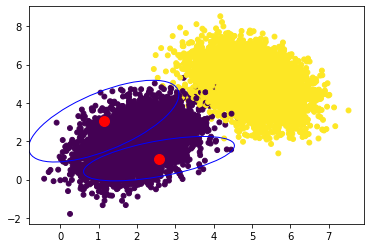

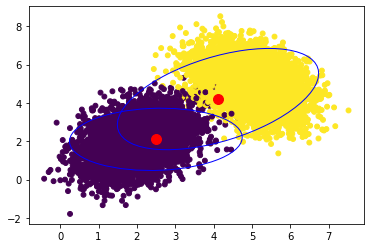

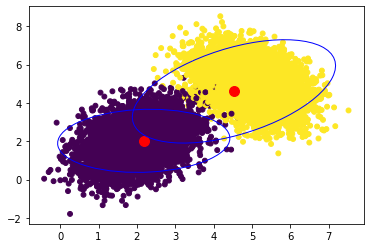

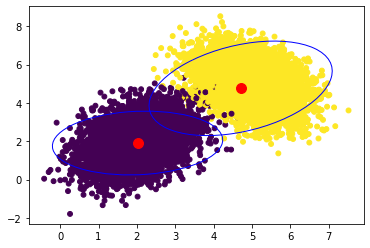

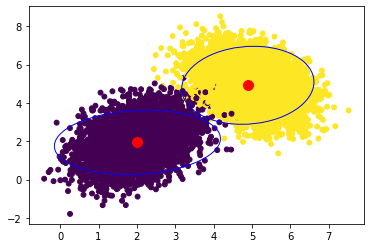

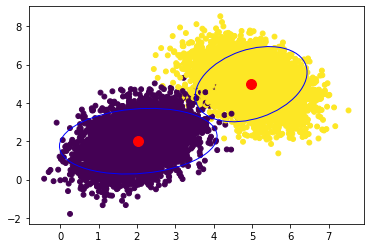

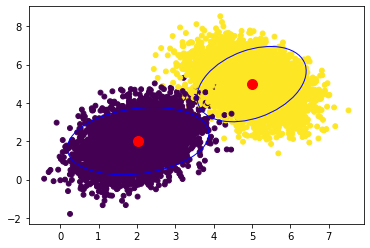

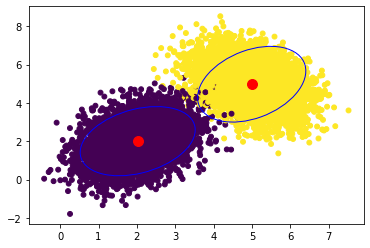

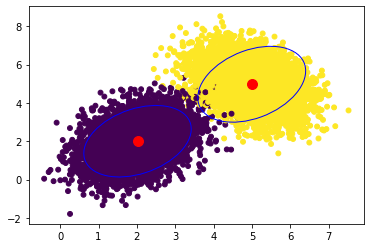

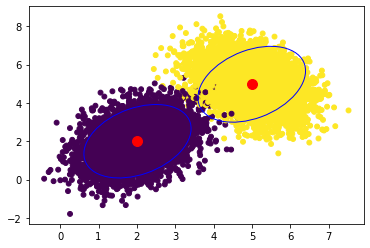

In [15]:
pyro.enable_validation(True)
pyro.set_rng_seed(101)

global_guide = AutoDiagonalNormal(poutine.block(model, expose=['weights', 'locs', 'scales'])) 
#global_guide = AutoDelta(poutine.block(model, expose=['weights', 'locs', 'scales']))
global_guide = config_enumerate(global_guide, 'parallel')
_, svi = initialize(data)

train_time = 0

for i in range(NUM_ITERS):

    t0 = time.time()
    loss = svi.step(data)
    train_time += time.time() - t0

    if i % 100 == 0:

        print('[iteration %i]\t loss: %.4f' % (i + 1, loss / N))

        locs = pyro.param('locs')
        scales = pyro.param('scales')
        weights = pyro.param('weights')
        assignment_probs = pyro.param('assignment_probs')

        # Plot data and estimates
        model_assignments = np.uint8(np.round(assignment_probs.data)) # not used 
        plot(data.detach().numpy(), locs.data, scales.data, assignments, figname='pyro_iteration{}.png'.format(i))

Multimodal example.

In [16]:
K = 3 

D = 2 

LOCS = torch.tensor([[2, 2], [5, 5], [3, 4]], dtype=torch.float)

SCALES = torch.tensor([[[.5, .25],
                        [.25, 1.]],
                       [[.5, -.25],
                        [-.25, 1.]],
                       [[1., 0],
                        [0, 1.]],
                       ], dtype=torch.float)

In [17]:
MULTIMODAL = GMM(K, D, LOCS, SCALES)

In [18]:
N = 10000

assert N > K, 'Dataset size N must be greater'

data, assignments = MULTIMODAL.sample(N)

data, assignments

(tensor([[6.1209, 4.3605],
         [1.6458, 1.6625],
         [2.9240, 2.7279],
         ...,
         [3.9600, 8.0363],
         [3.0563, 3.6509],
         [4.1987, 3.2762]]), tensor([2, 1, 0,  ..., 2, 1, 0]))

In [19]:
torch.manual_seed(7)
random.seed(7)

random_locs = [np.random.rand(D)]

temp = np.random.rand(D, D)
random_scales = [temp @ temp.T]

for _ in range(K - 1):
    
    random_locs.append(np.random.rand(D))

    temp = np.random.rand(D, D)
    random_scales.append(temp @ temp.T)
    
max_locs = torch.max(LOCS, 0).values

random_locs = torch.FloatTensor(np.array(random_locs)) * max_locs
random_scales = torch.FloatTensor(np.array(random_scales))

random_locs, random_scales

(tensor([[2.5820, 2.8533],
         [1.5348, 4.4681],
         [0.9095, 3.9280]]), tensor([[[0.0302, 0.1625],
          [0.1625, 1.1650]],
 
         [[0.5567, 0.4668],
          [0.4668, 0.4312]],
 
         [[0.9861, 0.2209],
          [0.2209, 0.3713]]]))

[iteration 1]	 loss: 131.8944
[iteration 101]	 loss: 4.6212
[iteration 201]	 loss: 4.1076
[iteration 301]	 loss: 3.6584
[iteration 401]	 loss: 3.4383
[iteration 501]	 loss: 3.4135
[iteration 601]	 loss: 3.4029
[iteration 701]	 loss: 3.3941
[iteration 801]	 loss: 3.3864
[iteration 901]	 loss: 3.3810


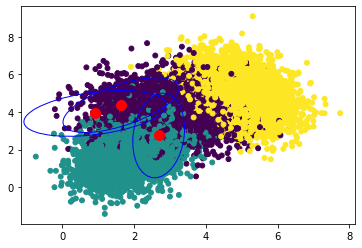

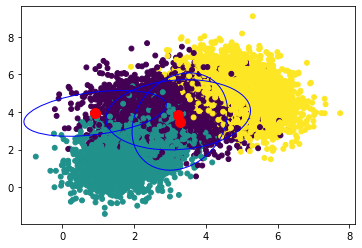

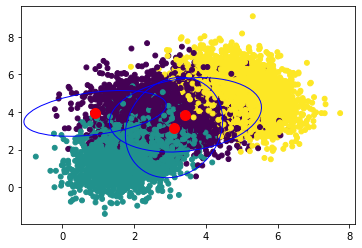

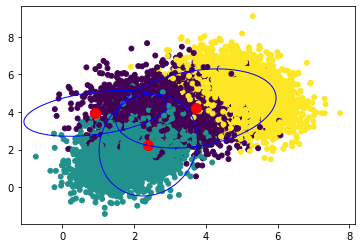

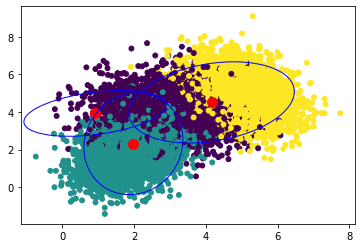

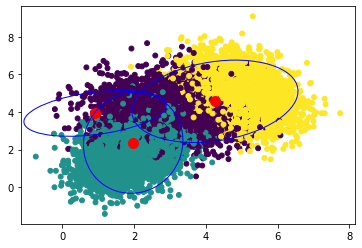

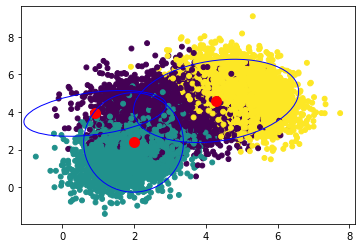

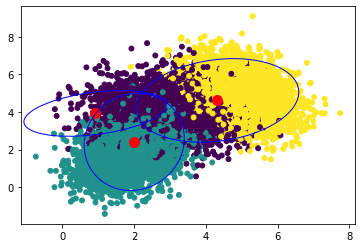

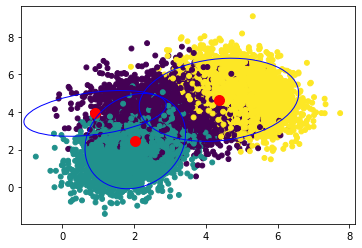

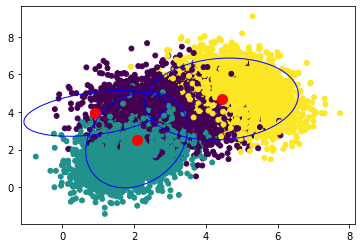

In [20]:
pyro.enable_validation(True)
pyro.set_rng_seed(101)

global_guide = AutoDiagonalNormal(poutine.block(model, expose=['weights', 'locs', 'scales'])) 
#global_guide = AutoDelta(poutine.block(model, expose=['weights', 'locs', 'scales']))
global_guide = config_enumerate(global_guide, 'parallel')
_, svi = initialize(data)

train_time = 0

for i in range(NUM_ITERS):

    t0 = time.time()
    loss = svi.step(data)
    train_time += time.time() - t0

    if i % 100 == 0:

        print('[iteration %i]\t loss: %.4f' % (i + 1, loss / N))

        locs = pyro.param('locs')
        scales = pyro.param('scales')
        weights = pyro.param('weights')
        assignment_probs = pyro.param('assignment_probs')

        # Plot data and estimates
        model_assignments = np.uint8(np.round(assignment_probs.data)) # not used 
        plot(data.detach().numpy(), locs.data, scales.data, assignments, figname='pyro_iteration{}.png'.format(i))

TODO: MCMC AND NUTS (https://pyro.ai/examples/gmm.html)